<a href="https://colab.research.google.com/github/hyunjin2123/BA_ToDo/blob/main/%5B%EC%84%9C%EC%9A%B8%EC%8B%9C%20%EA%B4%91%EC%A7%84%EA%B5%AC%5D%EA%B8%B0%EC%83%81_%EC%98%81%ED%96%A5%EC%97%90_%EB%94%B0%EB%A5%B8_%EC%A3%BC%EC%9A%94_%ED%8C%90%EB%A7%A4_%EC%83%81%ED%92%88_%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%ED%99%95%EC%9D%B8_%EB%B0%8F_%ED%8C%90%EB%A7%A4%EB%9F%89_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기상 영향에 따른 주요 판매 상품 카테고리 확인 및 판매량 예측

연구 목적

1) 기상 영향(평균기온,습도, 풍수, 강수량)별로 어떤 상품이 가장 잘 팔리는지 킬링 카테고리/상품 파악
2) 기상 영향에 따른 상품 또는 매장의 총판매량을 예측하여 상품 매입량 조절에 활용


연구 방법

1) 편의점의 일자별 판매량 데이터(12개 품목)
2) 일자별 기상청 데이터두 개의 데이터
3) 일자별 기상 지표와 상품별 판매량 데이터셋 생성
4) 변수별 상관관계 확인
5) 예측모델 적용
6) 기상 상황이 타겟 변수일 때의 상품 판매량 예측

연구 결론

더운날 아이스크림, 생수 상관관계가 가장 높음
상품과 매장을 축소해서 특이한 결합을 파악하기 어려웠음

In [ ]:
# 나눔 폰트 설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [93]:
#런타임 다시 시작 후,
# matplotlib 폰트를 나눔 폰트로 지ㅣ정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
import matplotlib as mpl               # 기본 설정
import matplotlib.pyplot as plt        # 그래프 관련
import matplotlib.font_manager as fm   # 폰트 관련
import seaborn as sns           # Seaborn 로딩하기
import os.path
import pandas as pd
import numpy as np
import lightgbm                         #LGBM 활용 - 기존 tree 기반 알고리즘과 달리 tree구조가 수직적으로 확장 *GBM이란 틀린부분에 가중치를 더하면서 진행하는 알고리즘
from tqdm import tqdm
import warnings

mpl.rcParams['axes.unicode_minus'] = False  ## 마이너스 부호가 깨지는 것 방지

#한글 사용하는 방법 !! 
#1. 먼저 나눔 폰트 설치
#2. 전체 폰트 갯수 중  나눔 폰트 갯수가 뜨는지 확인
#3. 런타임-런타임 다시 시작 후, 차트 plot 다시 실행

#!apt-get update -qq
#!apt-get install fonts-nanum* -qq              

#sys_font=fm.findSystemFonts()
#print(f"sys_font number: {len(sys_font)}")
#print(sys_font)                               

#nanum_font = [f for f in sys_font if 'Nanum' in f]
#print(f"nanum_font number: {len(nanum_font)}") 
#nanum_font

In [5]:
# 설치된 나눔글꼴중 원하는 폰트의 전체 경로 가져오기 
path = '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf'  
font_name = fm.FontProperties(fname=path, size=14).get_name()
print(font_name)

plt.rc('font', family=font_name)
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

NanumSquare
['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumPen.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/nanum/Nan

In [ ]:
# 간단하게 그림을 그릴 수 있는 mglearn 라이브러리 사용 (!pip install mglearn 명령어로 설치)
!pip install mglearn
import mglearn

In [7]:
# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

## 데이터셋 만들기

In [115]:
#GS25 상품 판매 데이터 불러오기

from pandas.core.frame import DataFrame

import pandas as pd

# csv 데이터 가져오기
df_GS25 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/최종과제/GS25.csv", encoding="cp949")

print(df_GS25.columns)
print(df_GS25.info())      #데이터정보파악 행, 열, 결측치 등
display(df_GS25.head(5))    #처음 5행 확인

Index(['korea_cvs.pvn_nm', 'korea_cvs.sale_dt', 'korea_cvs.gen_cd',
       'korea_cvs.age_cd', 'korea_cvs.category', 'korea_cvs.adj_qty',
       'korea_cvs.bor_nm'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707786 entries, 0 to 2707785
Data columns (total 7 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   korea_cvs.pvn_nm    object
 1   korea_cvs.sale_dt   int64 
 2   korea_cvs.gen_cd    object
 3   korea_cvs.age_cd    object
 4   korea_cvs.category  object
 5   korea_cvs.adj_qty   int64 
 6   korea_cvs.bor_nm    object
dtypes: int64(2), object(5)
memory usage: 144.6+ MB
None


,korea_cvs.pvn_nm,korea_cvs.sale_dt,korea_cvs.gen_cd,korea_cvs.age_cd,korea_cvs.category,korea_cvs.adj_qty,korea_cvs.bor_nm
0,서울특별시,20160101,F,00~19,라면,7,종로구
1,서울특별시,20160101,F,20~39,과자,655,종로구
2,서울특별시,20160101,F,20~39,라면,282,종로구
3,서울특별시,20160101,F,20~39,마스크,35,종로구
4,서울특별시,20160101,F,20~39,맥주,183,종로구


In [116]:
df_GS25.columns=['광역시','ymd','성별','연령대','상품','수량','시군구']
df_GS25

,광역시,ymd,성별,연령대,상품,수량,시군구
0,서울특별시,20160101,F,00~19,라면,7,종로구
1,서울특별시,20160101,F,20~39,과자,655,종로구
2,서울특별시,20160101,F,20~39,라면,282,종로구
3,서울특별시,20160101,F,20~39,마스크,35,종로구
4,서울특별시,20160101,F,20~39,맥주,183,종로구
...,...,...,...,...,...,...,...
2707781,경기도,20181230,M,40~59,과자,7,여주시이천시
2707782,경기도,20181231,F,00~19,맥주,7,여주시이천시
2707783,경기도,20181231,F,20~39,생리대,7,여주시이천시
2707784,경기도,20181231,F,60~99,생리대,7,여주시이천시


In [117]:
#종로구 자료만 선택
df_GS25_temp = df_GS25[df_GS25['시군구'] == '종로구'] # 시군구 열이 '종로구'인 행들만 추출
df_GS25_temp

,광역시,ymd,성별,연령대,상품,수량,시군구
0,서울특별시,20160101,F,00~19,라면,7,종로구
1,서울특별시,20160101,F,20~39,과자,655,종로구
2,서울특별시,20160101,F,20~39,라면,282,종로구
3,서울특별시,20160101,F,20~39,마스크,35,종로구
4,서울특별시,20160101,F,20~39,맥주,183,종로구
...,...,...,...,...,...,...,...
2519452,서울특별시,20181231,M,00~19,면도기,7,종로구
2519453,서울특별시,20181231,M,20~39,생리대,7,종로구
2519454,서울특별시,20181231,M,20~39,스타킹,7,종로구
2519455,서울특별시,20181231,M,40~59,마스크,7,종로구


In [118]:
df_GS25_temp = df_GS25_temp.drop(['광역시','성별','연령대','시군구'], axis=1)
df_GS25_temp

,ymd,상품,수량
0,20160101,라면,7
1,20160101,과자,655
2,20160101,라면,282
3,20160101,마스크,35
4,20160101,맥주,183
...,...,...,...
2519452,20181231,면도기,7
2519453,20181231,생리대,7
2519454,20181231,스타킹,7
2519455,20181231,마스크,7


In [119]:
df_GS25_temp.groupby(['ymd','상품']).수량.sum()

ymd       상품   
20160101  과자       1500
          라면        818
          마스크        56
          맥주        499
          면도기         7
                   ... 
20181231  생수        353
          숙취해소제       7
          스타킹        35
          아이스크림     239
          탄산음료      126
Name: 수량, Length: 11978, dtype: int64

In [120]:
product = pd.DataFrame(df_GS25_temp.groupby(['ymd','상품']).수량.sum()).reset_index()
df_GS25_final = product.pivot('ymd','상품','수량').fillna(0)
df_GS25_final

상품,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료
ymd,,,,,,,,,,,,
20160101,1500.0,818.0,56.0,499.0,7.0,85.0,274.0,35.0,28.0,514.0,0.0,98.0
20160102,1536.0,718.0,21.0,514.0,0.0,141.0,281.0,49.0,21.0,366.0,0.0,126.0
20160103,1437.0,853.0,14.0,380.0,42.0,77.0,345.0,21.0,28.0,578.0,0.0,105.0
20160104,1297.0,973.0,7.0,282.0,14.0,113.0,217.0,14.0,14.0,401.0,0.0,147.0
20160105,1395.0,937.0,0.0,360.0,7.0,77.0,253.0,105.0,35.0,408.0,0.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20181227,1008.0,1289.0,21.0,289.0,14.0,42.0,239.0,49.0,14.0,415.0,0.0,98.0
20181228,1536.0,1212.0,35.0,380.0,14.0,77.0,359.0,126.0,21.0,296.0,0.0,133.0
20181229,1289.0,746.0,21.0,268.0,7.0,49.0,401.0,42.0,21.0,232.0,0.0,49.0


In [121]:
df_total = df_GS25_final.sum(axis=1)
df_GS25_final.insert(12, '총 판매량',df_total)
df_GS25_final

상품,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료,총 판매량
ymd,,,,,,,,,,,,,
20160101,1500.0,818.0,56.0,499.0,7.0,85.0,274.0,35.0,28.0,514.0,0.0,98.0,3914.0
20160102,1536.0,718.0,21.0,514.0,0.0,141.0,281.0,49.0,21.0,366.0,0.0,126.0,3773.0
20160103,1437.0,853.0,14.0,380.0,42.0,77.0,345.0,21.0,28.0,578.0,0.0,105.0,3880.0
20160104,1297.0,973.0,7.0,282.0,14.0,113.0,217.0,14.0,14.0,401.0,0.0,147.0,3479.0
20160105,1395.0,937.0,0.0,360.0,7.0,77.0,253.0,105.0,35.0,408.0,0.0,77.0,3654.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181227,1008.0,1289.0,21.0,289.0,14.0,42.0,239.0,49.0,14.0,415.0,0.0,98.0,3478.0
20181228,1536.0,1212.0,35.0,380.0,14.0,77.0,359.0,126.0,21.0,296.0,0.0,133.0,4189.0
20181229,1289.0,746.0,21.0,268.0,7.0,49.0,401.0,42.0,21.0,232.0,0.0,49.0,3125.0


In [122]:
print(df_GS25_final.describe())

상품              과자           라면          마스크           맥주          면도기  \
count  1096.000000  1096.000000  1096.000000  1096.000000  1096.000000   
mean   1482.708029  1079.035584    26.665146   383.551095    12.824818   
std     291.678929   199.204655    47.159460   124.088586    11.071225   
min     662.000000   592.000000     0.000000    98.000000     0.000000   
25%    1268.000000   944.000000     7.000000   295.000000     7.000000   
50%    1473.000000  1070.500000    14.000000   366.000000    14.000000   
75%    1662.000000  1211.000000    28.000000   451.000000    21.000000   
max    2620.000000  2558.000000   621.000000  1021.000000    70.000000   

상품             생리대           생수        숙취해소제          스타킹        아이스크림  \
count  1096.000000  1096.000000  1096.000000  1096.000000  1096.000000   
mean     86.135949   522.141423    85.363139    42.876825   967.811131   
std      31.355973   211.904401    48.608693    34.611719   656.202305   
min       7.000000   154.000000     0

In [123]:
#기상청 기상 데이터 불러오기

# csv 데이터 가져오기
df_wether = pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/최종과제/기상데이터.csv", encoding="cp949")

print(df_wether.columns)
print(df_wether.info())      #데이터정보파악 행, 열, 결측치 등
display(df_wether.head(5))      #처음 5행 확인

Index(['bigcon_weather.tm', 'bigcon_weather.stn_id', 'bigcon_weather.pvn_nm',
       'bigcon_weather.bor_nm', 'bigcon_weather.max_ta',
       'bigcon_weather.max_ws', 'bigcon_weather.min_ta',
       'bigcon_weather.avg_ta', 'bigcon_weather.avg_rhm',
       'bigcon_weather.avg_ws', 'bigcon_weather.sum_rn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59113 entries, 0 to 59112
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bigcon_weather.tm       59113 non-null  int64  
 1   bigcon_weather.stn_id   59113 non-null  int64  
 2   bigcon_weather.pvn_nm   59113 non-null  object 
 3   bigcon_weather.bor_nm   59113 non-null  object 
 4   bigcon_weather.max_ta   58826 non-null  float64
 5   bigcon_weather.max_ws   58778 non-null  float64
 6   bigcon_weather.min_ta   58826 non-null  float64
 7   bigcon_weather.avg_ta   58814 non-null  float64
 8   bigcon_weather.avg_rhm  43

,bigcon_weather.tm,bigcon_weather.stn_id,bigcon_weather.pvn_nm,bigcon_weather.bor_nm,bigcon_weather.max_ta,bigcon_weather.max_ws,bigcon_weather.min_ta,bigcon_weather.avg_ta,bigcon_weather.avg_rhm,bigcon_weather.avg_ws,bigcon_weather.sum_rn
0,20160101,98,경기도,동두천시,6.5,3.8,-6.4,-0.2,74.0,0.9,0.0
1,20160102,98,경기도,동두천시,10.1,3.2,1.9,5.4,70.0,1.3,0.0
2,20160103,98,경기도,동두천시,9.0,2.4,2.1,4.7,82.0,0.7,0.0
3,20160104,98,경기도,동두천시,8.0,5.3,-3.0,1.9,55.0,2.2,0.0
4,20160105,98,경기도,동두천시,3.1,5.6,-6.4,-2.8,36.0,1.8,0.0


In [124]:
df_wether_temp = df_wether.drop(columns = ['bigcon_weather.stn_id','bigcon_weather.max_ta','bigcon_weather.max_ws','bigcon_weather.min_ta'])
df_wether_temp.head()

,bigcon_weather.tm,bigcon_weather.pvn_nm,bigcon_weather.bor_nm,bigcon_weather.avg_ta,bigcon_weather.avg_rhm,bigcon_weather.avg_ws,bigcon_weather.sum_rn
0,20160101,경기도,동두천시,-0.2,74.0,0.9,0.0
1,20160102,경기도,동두천시,5.4,70.0,1.3,0.0
2,20160103,경기도,동두천시,4.7,82.0,0.7,0.0
3,20160104,경기도,동두천시,1.9,55.0,2.2,0.0
4,20160105,경기도,동두천시,-2.8,36.0,1.8,0.0


In [125]:
df_wether_temp.columns=['ymd','광역시','시군구','평균기온','습도','평균풍속','강수량']
df_wether_temp

,ymd,광역시,시군구,평균기온,습도,평균풍속,강수량
0,20160101,경기도,동두천시,-0.2,74.0,0.9,0.0
1,20160102,경기도,동두천시,5.4,70.0,1.3,0.0
2,20160103,경기도,동두천시,4.7,82.0,0.7,0.0
3,20160104,경기도,동두천시,1.9,55.0,2.2,0.0
4,20160105,경기도,동두천시,-2.8,36.0,1.8,0.0
...,...,...,...,...,...,...,...
59108,20181227,경기도,연천군,-10.2,35.0,1.6,0.0
59109,20181228,경기도,연천군,-12.2,48.0,1.1,0.0
59110,20181229,경기도,연천군,-9.3,46.0,1.2,0.0
59111,20181230,경기도,연천군,-10.3,56.0,0.8,0.0


In [126]:
#기상데이터도 종로구 자료만 선택
df_wether_final = df_wether_temp[df_wether_temp['시군구'] == '종로구'] # 시군구 열이 '종로구'인 행들만 추출
df_wether_final.head(10)

,ymd,광역시,시군구,평균기온,습도,평균풍속,강수량
2192,20160101,서울특별시,종로구,1.2,73.0,1.6,0.0
2193,20160102,서울특별시,종로구,5.7,77.0,2.0,0.0
2194,20160103,서울특별시,종로구,6.5,81.0,1.8,0.0
2195,20160104,서울특별시,종로구,2.0,54.0,3.1,0.0
2196,20160105,서울특별시,종로구,-2.7,39.0,2.3,0.0
2197,20160106,서울특별시,종로구,-1.7,54.0,1.8,0.0
2198,20160107,서울특별시,종로구,-3.4,52.0,2.5,0.0
2199,20160108,서울특별시,종로구,-3.3,50.0,2.0,0.0
2200,20160109,서울특별시,종로구,-2.1,57.0,2.1,0.0
2201,20160110,서울특별시,종로구,0.3,42.0,2.6,0.0


In [127]:
df_wether_final = df_wether_final.drop(['광역시','시군구',], axis=1)
df_wether_final.tail()

,ymd,평균기온,습도,평균풍속,강수량
3283,20181227,-10.1,28.0,3.5,0.0
3284,20181228,-10.5,33.0,2.5,0.0
3285,20181229,-7.6,29.0,2.9,0.0
3286,20181230,-6.8,36.0,1.2,0.0
3287,20181231,-5.4,40.0,1.2,0.0


In [128]:
df_wether_final = df_wether_final.fillna(0)
df_wether_final.isnull().sum()

ymd     0
평균기온    0
습도      0
평균풍속    0
강수량     0
dtype: int64

In [129]:
#gs 데이터와 기상 데이터 결합하기

df = pd.merge( df_wether_final, df_GS25_final,on="ymd", how="left")
df.info()  #1096개 데이터로 3년 모두 포함되어 있음을 확인
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1095
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ymd     1096 non-null   int64  
 1   평균기온    1096 non-null   float64
 2   습도      1096 non-null   float64
 3   평균풍속    1096 non-null   float64
 4   강수량     1096 non-null   float64
 5   과자      1096 non-null   float64
 6   라면      1096 non-null   float64
 7   마스크     1096 non-null   float64
 8   맥주      1096 non-null   float64
 9   면도기     1096 non-null   float64
 10  생리대     1096 non-null   float64
 11  생수      1096 non-null   float64
 12  숙취해소제   1096 non-null   float64
 13  스타킹     1096 non-null   float64
 14  아이스크림   1096 non-null   float64
 15  우산      1096 non-null   float64
 16  탄산음료    1096 non-null   float64
 17  총 판매량   1096 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 162.7 KB


,ymd,평균기온,습도,평균풍속,강수량,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료,총 판매량
0,20160101,1.2,73.0,1.6,0.0,1500.0,818.0,56.0,499.0,7.0,85.0,274.0,35.0,28.0,514.0,0.0,98.0,3914.0
1,20160102,5.7,77.0,2.0,0.0,1536.0,718.0,21.0,514.0,0.0,141.0,281.0,49.0,21.0,366.0,0.0,126.0,3773.0
2,20160103,6.5,81.0,1.8,0.0,1437.0,853.0,14.0,380.0,42.0,77.0,345.0,21.0,28.0,578.0,0.0,105.0,3880.0
3,20160104,2.0,54.0,3.1,0.0,1297.0,973.0,7.0,282.0,14.0,113.0,217.0,14.0,14.0,401.0,0.0,147.0,3479.0
4,20160105,-2.7,39.0,2.3,0.0,1395.0,937.0,0.0,360.0,7.0,77.0,253.0,105.0,35.0,408.0,0.0,77.0,3654.0


In [130]:
from datetime import datetime
df['ymd']= df['ymd'].astype('str')
df['ymd'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1091   2018-12-27
1092   2018-12-28
1093   2018-12-29
1094   2018-12-30
1095   2018-12-31
Name: ymd, Length: 1096, dtype: datetime64[ns]

In [131]:
df.set_index('ymd', inplace=True)
df

,평균기온,습도,평균풍속,강수량,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료,총 판매량
ymd,,,,,,,,,,,,,,,,,
20160101,1.2,73.0,1.6,0.0,1500.0,818.0,56.0,499.0,7.0,85.0,274.0,35.0,28.0,514.0,0.0,98.0,3914.0
20160102,5.7,77.0,2.0,0.0,1536.0,718.0,21.0,514.0,0.0,141.0,281.0,49.0,21.0,366.0,0.0,126.0,3773.0
20160103,6.5,81.0,1.8,0.0,1437.0,853.0,14.0,380.0,42.0,77.0,345.0,21.0,28.0,578.0,0.0,105.0,3880.0
20160104,2.0,54.0,3.1,0.0,1297.0,973.0,7.0,282.0,14.0,113.0,217.0,14.0,14.0,401.0,0.0,147.0,3479.0
20160105,-2.7,39.0,2.3,0.0,1395.0,937.0,0.0,360.0,7.0,77.0,253.0,105.0,35.0,408.0,0.0,77.0,3654.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181227,-10.1,28.0,3.5,0.0,1008.0,1289.0,21.0,289.0,14.0,42.0,239.0,49.0,14.0,415.0,0.0,98.0,3478.0
20181228,-10.5,33.0,2.5,0.0,1536.0,1212.0,35.0,380.0,14.0,77.0,359.0,126.0,21.0,296.0,0.0,133.0,4189.0
20181229,-7.6,29.0,2.9,0.0,1289.0,746.0,21.0,268.0,7.0,49.0,401.0,42.0,21.0,232.0,0.0,49.0,3125.0


In [132]:
print(df.columns) #기상 4개, 상품 12개+1개,  총 17개

Index(['평균기온', '습도', '평균풍속', '강수량', '과자', '라면', '마스크', '맥주', '면도기', '생리대',
       '생수', '숙취해소제', '스타킹', '아이스크림', '우산', '탄산음료', '총 판매량'],
      dtype='object')


##데이터 탐색


In [133]:
# 기술통계 확인하기
print(df.describe())

              평균기온          습도         평균풍속          강수량           과자  \
count  1096.000000  1096.00000  1096.000000  1096.000000  1096.000000   
mean     13.223358    58.05292     2.067792     3.167427  1482.708029   
std      11.166435    14.53030     0.708135    12.686887   291.678929   
min     -14.800000    22.00000     0.000000     0.000000   662.000000   
25%       3.475000    47.00000     1.600000     0.000000  1268.000000   
50%      14.650000    58.00000     2.000000     0.000000  1473.000000   
75%      22.900000    68.00000     2.500000     0.000000  1662.000000   
max      33.700000    97.00000     5.400000   144.500000  2620.000000   

                라면          마스크           맥주          면도기          생리대  \
count  1096.000000  1096.000000  1096.000000  1096.000000  1096.000000   
mean   1079.035584    26.665146   383.551095    12.824818    86.135949   
std     199.204655    47.159460   124.088586    11.071225    31.355973   
min     592.000000     0.000000    98.000000  

In [134]:
# 상관계수 확인하기 1 - 매트릭스 형태
corr_df = df.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,평균기온,습도,평균풍속,강수량,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료,총 판매량
평균기온,1.00,0.41,-0.19,0.15,0.05,-0.14,-0.18,0.48,0.05,0.18,0.46,-0.04,-0.11,0.82,0.12,0.40,0.69
습도,0.41,1.00,-0.13,0.45,0.09,-0.03,-0.07,0.18,0.03,0.03,0.05,-0.02,-0.16,0.19,0.40,0.03,0.21
평균풍속,-0.19,-0.13,1.00,0.04,0.20,0.13,0.01,-0.05,0.05,0.03,-0.11,0.01,0.15,-0.09,0.01,-0.08,-0.00
강수량,0.15,0.45,0.04,1.00,0.04,0.01,-0.09,0.08,-0.05,-0.07,-0.12,-0.07,-0.10,-0.00,0.38,-0.09,0.02
과자,0.05,0.09,0.20,0.04,1.00,0.23,-0.00,0.35,0.16,0.10,0.20,0.16,0.09,0.22,0.12,0.12,0.58
라면,-0.14,-0.03,0.13,0.01,0.23,1.00,0.05,-0.04,0.08,0.09,0.09,0.24,0.32,-0.13,0.09,0.24,0.25
마스크,-0.18,-0.07,0.01,-0.09,-0.00,0.05,1.00,-0.17,-0.03,-0.02,-0.02,0.09,0.15,-0.19,-0.06,0.03,-0.09
맥주,0.48,0.18,-0.05,0.08,0.35,-0.04,-0.17,1.00,0.07,0.16,0.35,0.05,-0.12,0.52,0.06,0.24,0.62
면도기,0.05,0.03,0.05,-0.05,0.16,0.08,-0.03,0.07,1.00,0.10,0.07,0.07,0.08,0.11,0.04,0.02,0.17
생리대,0.18,0.03,0.03,-0.07,0.10,0.09,-0.02,0.16,0.10,1.00,0.16,0.11,0.18,0.15,0.00,0.11,0.24


In [135]:
# 상관계수 확인하기 2 - 시리즈 형태
s = corr_df.unstack()
s

평균기온   평균기온     1.00
       습도       0.41
       평균풍속    -0.19
       강수량      0.15
       과자       0.05
                ... 
총 판매량  스타킹      0.06
       아이스크림    0.82
       우산       0.17
       탄산음료     0.52
       총 판매량    1.00
Length: 289, dtype: float64

In [136]:
# 상관계수 확인하기 3 - DataFrame의 style프로퍼티 형태
corr_df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
corr_df.style.background_gradient(cmap='viridis')    # 0.4 이상을 유의미하다고 봄

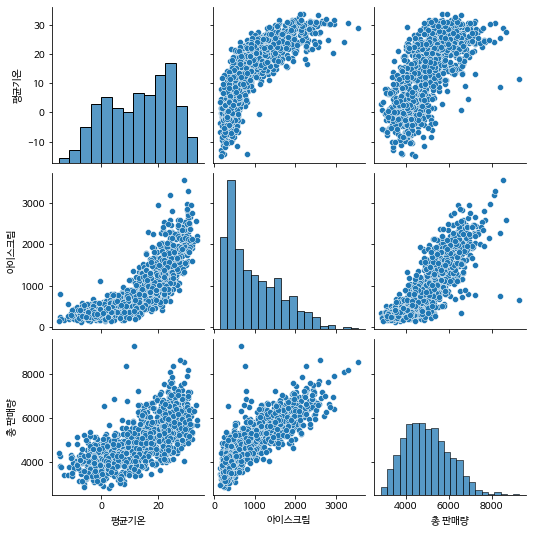

In [140]:
# scatter
cols = ["평균기온","아이스크림", "총 판매량"]
sns.pairplot(df[cols])
plt.show()

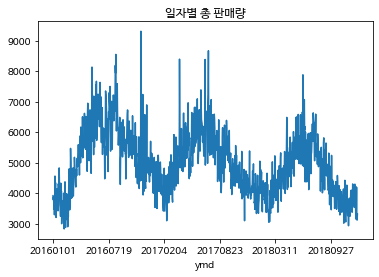

In [141]:
df['총 판매량'].plot(title = '일자별 총 판매량')

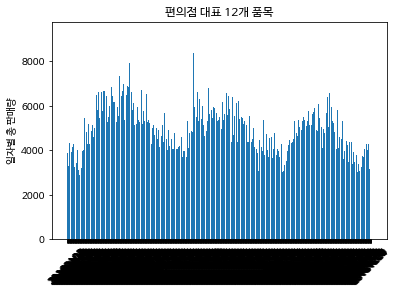

In [143]:
ymd = df.index.tolist()
qty = df['총 판매량'].values.tolist()
 
plt.bar(ymd, qty, align='center')
plt.ylabel('일자별 총 판매량')
plt.title('편의점 대표 12개 품목')
plt.xticks(rotation=45) 
plt.show()


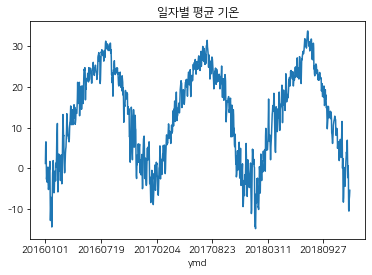

In [29]:
df['평균기온'].plot(title = '일자별 평균 기온')

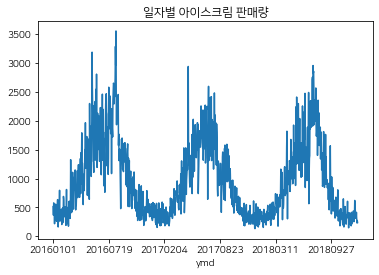

In [31]:
df['아이스크림'].plot(title = '일자별 아이스크림 판매량')

In [ ]:
##그리드서치


#회귀분석

In [55]:
# Python ≥3.5 이상을 권장
import sys
print("Python version: {}".format(sys.version))

# Scikit-Learn ≥0.20 이상을 권장
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
scikit-learn version: 1.0.2


## 데이터 전처리
 - 학습/테스트데이터 분할
 - 독립변수 표준화 수행


In [68]:
exp_df = df
display(exp_df.head(3))
exp_df.describe()  #변수 scale확인
print(exp_df.isnull().sum())  #결측치 확인

,평균기온,습도,평균풍속,강수량,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료,총 판매량
ymd,,,,,,,,,,,,,,,,,
20160101,1.2,73.0,1.6,0.0,1500.0,818.0,56.0,499.0,7.0,85.0,274.0,35.0,28.0,514.0,0.0,98.0,3914.0
20160102,5.7,77.0,2.0,0.0,1536.0,718.0,21.0,514.0,0.0,141.0,281.0,49.0,21.0,366.0,0.0,126.0,3773.0
20160103,6.5,81.0,1.8,0.0,1437.0,853.0,14.0,380.0,42.0,77.0,345.0,21.0,28.0,578.0,0.0,105.0,3880.0


평균기온     0
습도       0
평균풍속     0
강수량      0
과자       0
라면       0
마스크      0
맥주       0
면도기      0
생리대      0
생수       0
숙취해소제    0
스타킹      0
아이스크림    0
우산       0
탄산음료     0
총 판매량    0
dtype: int64


In [76]:
y = exp_df["아이스크림"]
X = exp_df.iloc[:,0:-4]
display(X.head())

,평균기온,습도,평균풍속,강수량,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹
ymd,,,,,,,,,,,,,
20160101,1.2,73.0,1.6,0.0,1500.0,818.0,56.0,499.0,7.0,85.0,274.0,35.0,28.0
20160102,5.7,77.0,2.0,0.0,1536.0,718.0,21.0,514.0,0.0,141.0,281.0,49.0,21.0
20160103,6.5,81.0,1.8,0.0,1437.0,853.0,14.0,380.0,42.0,77.0,345.0,21.0,28.0
20160104,2.0,54.0,3.1,0.0,1297.0,973.0,7.0,282.0,14.0,113.0,217.0,14.0,14.0
20160105,-2.7,39.0,2.3,0.0,1395.0,937.0,0.0,360.0,7.0,77.0,253.0,105.0,35.0


In [77]:
# 학습 / 테스트데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [78]:
# 독립변수 표준화 
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler()
s_scaler.fit_transform(X_train)
s_scaler.transform(X_test)

array([[-1.44,  1.03,  3.62, ..., -1.54, -1.47, -0.64],
       [ 1.43,  1.24,  0.33, ...,  0.05, -0.19, -0.84],
       [-1.01, -1.2 ,  0.19, ..., -0.31,  1.08, -0.64],
       ...,
       [-1.14,  0.48, -0.82, ...,  0.57,  0.51, -0.64],
       [-0.01,  1.59, -0.96, ..., -0.21,  0.66,  1.79],
       [ 0.16, -0.99, -0.96, ...,  4.  ,  1.65,  2.63]])

In [79]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_predict = lr_model.predict(X_test)

In [84]:
train_performance = lr_model.score(X_train, y_train)
test_performance = lr_model.score(X_test, y_test)
print("아이스크림 판매량 예측결과: \n", y_predict[0:10])
print("훈련 성능: {}   테스트 성능: {}".format(train_performance, test_performance))
print(X_train.columns)

np.set_printoptions(suppress=True, precision =2) #넘파이 결과가 지수형태로 나와서 보기 안좋아서 지수 제한
print("회귀식: {}  절편: {}".format(lr_model.coef_, lr_model.intercept_))

#독립변수가 종속변수의 변동을 72.7% 설명
#그러나, 머신러닝에서는 MAE, RMSE를 더 중요한 성능으로 고려함

아이스크림 판매량 예측결과: 
 [  14.74 1825.72  615.63 1361.55 1472.11 1157.24  209.29  462.53 1007.08
 1165.19]
훈련 성능: 0.7584759845679323   테스트 성능: 0.7275898296151333
Index(['평균기온', '습도', '평균풍속', '강수량', '과자', '라면', '마스크', '맥주', '면도기', '생리대',
       '생수', '숙취해소제', '스타킹'],
      dtype='object')
회귀식: [50.7  -7.66 24.21 -3.58  0.41 -0.01 -0.38  0.33  2.67  0.04 -0.06  0.24
 -2.22]  절편: 69.4322746181723


In [85]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#mean_absolute_error(실제, 예측)
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

#MAE기준으로 해석하면, 회귀식이 평균적으로 예측한 아이스크림판매량은 실제값과 약 249개 정도 오차가 있음.

MAE: 249.55343085902655
RMSE: 107576.97003673018


## Feature Engineering

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly =PolynomialFeatures(degree = 2, include_bias = False)  #2제곱까지, include_bias = False 절편은 포함 안함. 회귀식에서 자동으로 포함하니 불필요
poly.fit(X_train)
train_poly = poly.transform(X_train)
test_poly = poly.transform(X_test)

print(train_poly.shape)
print(test_poly.shape)
poly.get_feature_names()

In [87]:
lr_model2 = LinearRegression()
lr_model2.fit(train_poly, y_train)
y_predict = lr_model2.predict(test_poly)
train_performance2 = lr_model2.score(train_poly, y_train)
test_performance2 = lr_model2.score(test_poly, y_test)
print("훈련 성능: {}   테스트 성능: {}".format(train_performance2, test_performance2))
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

#R2가 향상되었으며, 오차율이 줄어듦
#실제 아이스크림 판매량과 예측 아이스크림 판매량이 평균 213개 정도 차이남

훈련 성능: 0.842342457758289   테스트 성능: 0.7780022308199868
MAE: 213.2783308516839
RMSE: 87668.70682382546


In [88]:
# 학습/테스트 : 층화 추출
# 회귀식 변수 선택 *


# 구체적인 모형의 도출
import numpy as np
np.set_printoptions(suppress=True, precision =2) #넘파이 결과가 지수형태로 나와서 보기 안좋아서 지수 제한

print("회귀계수: {}  절편:{}".format(lr_model2.coef_, lr_model2.intercept_))

회귀계수: [ -1.67  -9.04  63.18  -9.97   0.31  -0.43   1.97   1.92  -2.82   4.25
  -1.19   2.52   1.27   1.91  -0.44  -4.11  -0.67   0.01   0.01  -0.03
   0.02  -0.02   0.02   0.01   0.06   0.03   0.14   2.6    0.17  -0.
   0.     0.02  -0.01  -0.08  -0.04   0.    -0.04   0.01 -31.41  -0.6
  -0.08  -0.02   0.42   0.02  -0.7   -0.76   0.18   0.58   0.53   0.06
  -0.    -0.    -0.07   0.01   0.06   0.03   0.02  -0.08   0.03   0.
   0.    -0.    -0.     0.01  -0.     0.    -0.     0.    -0.    -0.
   0.    -0.    -0.     0.     0.    -0.    -0.    -0.    -0.05  -0.01
   0.    -0.01   0.     0.     0.    -0.    -0.    -0.    -0.     0.05
   0.02   0.    -0.    -0.03   0.     0.    -0.     0.02   0.    -0.
  -0.    -0.     0.    -0.01]  절편:45.17342630242899


##회귀분석 - sklearn 이용 - Ridge & Lasso 회귀분석

In [90]:
from sklearn.linear_model import Ridge  #Lasso는 Ridge를 Lasso로만 변경

Ridge = Ridge(alpha = 0.3)
Ridge.fit(train_poly, y_train)
y_predict = Ridge.predict(test_poly)
train_performance3 = Ridge.score(train_poly, y_train)
test_performance3 = Ridge.score(test_poly, y_test)
print("훈련 성능: {}   테스트 성능: {}".format(train_performance3, test_performance3))
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

print("회귀계수: {}  절편:{}".format(Ridge.coef_, Ridge.intercept_))

# 학습/테스트 데이터 변동 없음
#MAE도 동일

훈련 성능: 0.8423422185735743   테스트 성능: 0.7780173891636649
MAE: 213.29176355545007
RMSE: 87662.72067183504
회귀계수: [ -1.7   -9.13  58.    -9.85   0.31  -0.44   1.96   1.92  -2.8    4.25
  -1.2    2.53   1.29   1.91  -0.44  -4.12  -0.67   0.01   0.01  -0.03
   0.02  -0.02   0.02   0.01   0.06   0.03   0.14   2.63   0.16  -0.
   0.     0.02  -0.01  -0.08  -0.04   0.    -0.04   0.01 -31.22  -0.62
  -0.07  -0.02   0.42   0.02  -0.7   -0.75   0.18   0.58   0.53   0.06
  -0.    -0.    -0.07   0.01   0.06   0.03   0.02  -0.08   0.03   0.
   0.    -0.    -0.     0.01  -0.     0.    -0.     0.    -0.    -0.
   0.    -0.    -0.     0.     0.    -0.    -0.    -0.    -0.05  -0.01
   0.    -0.01   0.     0.     0.    -0.    -0.    -0.    -0.     0.05
   0.02   0.    -0.    -0.03   0.     0.    -0.     0.02   0.    -0.
  -0.    -0.     0.    -0.01]  절편:53.87315799643682


In [91]:
from sklearn.linear_model import Lasso  #Lasso는 Ridge를 Lasso로만 변경

Lasso = Lasso(alpha = 0.3)
Lasso.fit(train_poly, y_train)
y_predict = Lasso.predict(test_poly)
train_performance3 = Lasso.score(train_poly, y_train)
test_performance3 = Lasso.score(test_poly, y_test)
print("훈련 성능: {}   테스트 성능: {}".format(train_performance3, test_performance3))
print("MAE:", mean_absolute_error(y_test, y_predict ))
print("RMSE:", mean_squared_error(y_test, y_predict))

print("회귀계수: {}  절편:{}".format(Lasso.coef_, Lasso.intercept_))

# 학습/테스트 데이터 변동 없음
#MAE도 동일

훈련 성능: 0.842263808659431   테스트 성능: 0.7774639233006885
MAE: 213.4789829936558
RMSE: 87881.28879825136
회귀계수: [ -4.28 -10.9    0.    -5.12   0.25  -0.47   1.47   1.9   -2.3    4.27
  -1.18   2.7    1.39   1.91  -0.44  -4.16  -0.66   0.01   0.01  -0.03
   0.02  -0.01   0.03   0.01   0.06   0.02   0.15   2.92   0.13  -0.
   0.     0.02  -0.01  -0.09  -0.04   0.    -0.04   0.01 -28.53  -0.73
  -0.07  -0.01   0.48   0.03  -0.7   -0.71   0.19   0.58   0.5    0.07
  -0.    -0.    -0.08   0.01   0.05   0.03   0.02  -0.08   0.03   0.
   0.    -0.    -0.     0.01  -0.     0.    -0.     0.    -0.     0.
   0.    -0.    -0.     0.     0.    -0.    -0.     0.    -0.04  -0.01
   0.    -0.01   0.     0.     0.    -0.    -0.    -0.    -0.     0.05
   0.02   0.     0.    -0.03   0.     0.    -0.     0.02   0.    -0.
  -0.    -0.     0.    -0.01]  절편:235.46039586611278
